### Homework Assignment 2 - Business Analytics MGMT 325 - MSSM AUA

Problem 1 ​(30 points). ​​Use Employee_attition.csv dataset uploaded to Moodle to analyze employee churn. Use Logistic Regression model to identify the variables that have significant effect on employee decision to leave. Evaluate and summarize the model results.

In [443]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#importing models that will be applied
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
import statsmodels.api as sm

#some preprocessing tools to automate the data preperation
from sklearn.preprocessing import scale, StandardScaler

#model evaluation metrics
from sklearn.metrics import recall_score, roc_auc_score, mean_squared_error, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# to ignore warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

# magic to not to call show every time 
%matplotlib inline

#### Exploratory Data Analysis

In [444]:
data_raw = pd.read_csv('https://raw.githubusercontent.com/raffisahakyan/Raw_Data/master/Employee_attrition.csv')
data_raw.info()
print("\n"+"-"*80+'\n')
data_raw.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


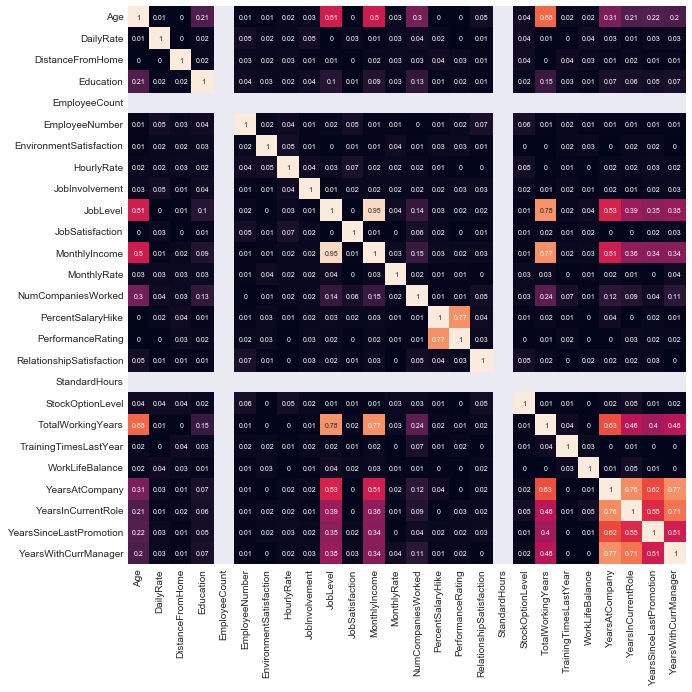

In [445]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(data_raw.select_dtypes(exclude=["object"]).corr().abs().round(2), 
                 annot=True, annot_kws = { "size" : 7 }, square=True, cbar=False)

In [446]:
#Benchmarking
print("Probability of Not Churn:",(100*(data_raw['Attrition']=='No').sum()/len(data_raw['Attrition'])))
print("Probability of Churn:",(100*(data_raw['Attrition']=='Yes').sum()/len(data_raw['Attrition'])))

Probability of Not Churn: 83.87755102040816
Probability of Churn: 16.122448979591837


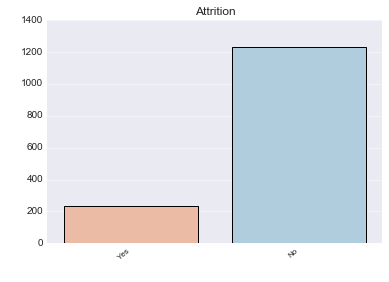

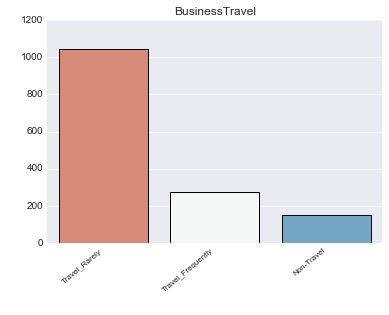

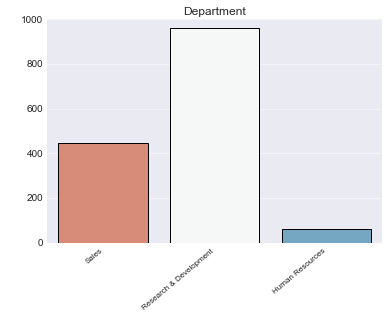

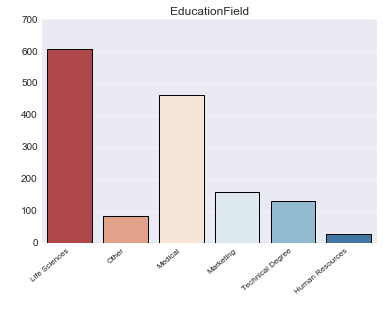

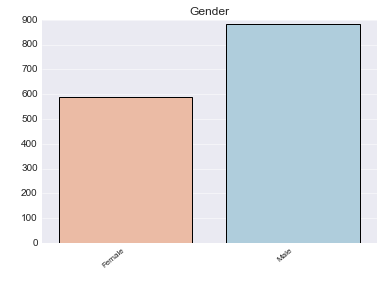

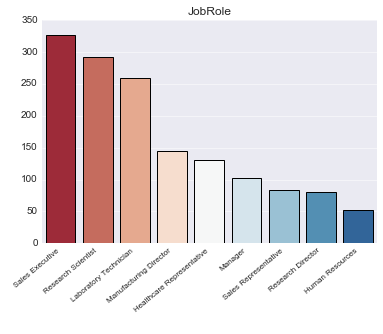

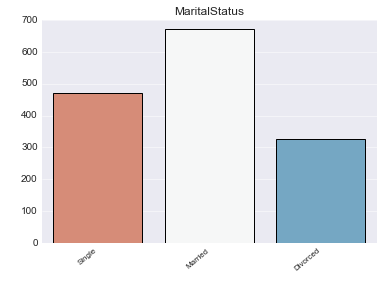

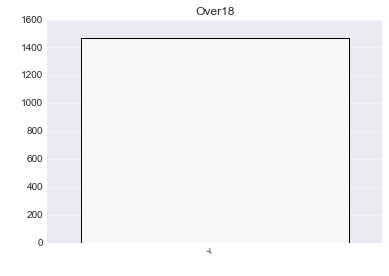

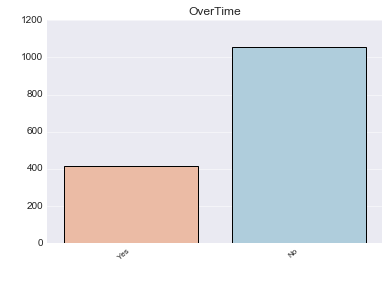

In [447]:
sns.set_style("darkgrid")
for i in data_raw.select_dtypes(include=["object"]).columns:
    ax = sns.countplot(data_raw.select_dtypes(include=["object"])[i], 
                       palette='RdBu')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, 
                       rotation=40, ha="right")
    ax.set_title(i)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    plt.show()

#### Data Preprocessing

In [448]:
data_raw = data_raw.loc[:,data_raw.apply(pd.Series.nunique) != 1]

In [449]:
data_raw['Attrition']=data_raw['Attrition'].astype("category").cat.reorder_categories(['No','Yes']).cat.codes 
data_raw['Gender']=data_raw['Gender'].astype("category").cat.reorder_categories(['Female','Male']).cat.codes 
data_raw['OverTime']=data_raw['OverTime'].astype("category").cat.reorder_categories(['No','Yes']).cat.codes 

In [450]:
dummies=pd.get_dummies(data_raw[['MaritalStatus','JobRole','Department','EducationField','BusinessTravel']],drop_first=True, prefix_sep='_')

In [451]:
#dropping also EmployeeNumber since it does not provide any additional information
data_raw.drop(['MaritalStatus','JobRole',"Department",'EducationField','BusinessTravel', 'EmployeeNumber'], 
              axis=1, inplace=True)
data_clean = data_raw.join(dummies)

print(data_clean.head(2))
print("-"*30)
print(data_clean.info())

   Age  Attrition  DailyRate  DistanceFromHome  Education  \
0   41          1       1102                 1          2   
1   49          0        279                 8          1   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  \
0                        2       0          94               3         2   
1                        3       1          61               2         2   

               ...               JobRole_Sales Representative  \
0              ...                                          0   
1              ...                                          0   

   Department_Research & Development  Department_Sales  \
0                                  0                 1   
1                                  1                 0   

   EducationField_Life Sciences  EducationField_Marketing  \
0                             1                         0   
1                             1                         0   

   EducationField_Medical  Educa

In [452]:
scaler = StandardScaler()
scaler.fit(data_clean.drop('Attrition',axis=1)) 
x_scaled = pd.DataFrame(scaler.transform(data_clean.drop('Attrition',axis=1)),
                        columns = data_clean.drop('Attrition',axis=1).columns)
y=data_clean['Attrition']

x_train, x_test, y_train, y_test = train_test_split(x_scaled, 
                                                    y,test_size=.25, random_state=42, 
                                                    stratify=y)
#We stratify Y to include equal proportions of 0,1 in y data

#### Model Initiation & Evaluation

In [453]:
model_logit = LogisticRegression(random_state=42, class_weight='balanced')
model_logit.fit(x_train,y_train)
print("Accuracy on train set",round(model_logit.score(x_train,y_train)*100,3),"%")
print("Accuracy on test set",round(model_logit.score(x_test,y_test)*100,3),"%")

Accuracy on train set 78.584 %
Accuracy on test set 77.717 %


In [454]:
logit_pred = model_logit.predict(x_test)
print("Mean Squared Error",round(mean_squared_error(y_test,logit_pred),3))
print("Roc Auc Score",round(roc_auc_score(y_test,logit_pred)*100,3),"%")
print("Mean of Cross-Validation Scores",round(cross_val_score(model_logit,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').std(),3))

Mean Squared Error 0.223
Roc Auc Score 72.333 %
Mean of Cross-Validation Scores 0.026


In [455]:
print(confusion_matrix(y_test, logit_pred))
print("-"*100)
print(classification_report(y_test, logit_pred))

[[248  61]
 [ 21  38]]
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.92      0.80      0.86       309
          1       0.38      0.64      0.48        59

avg / total       0.84      0.78      0.80       368



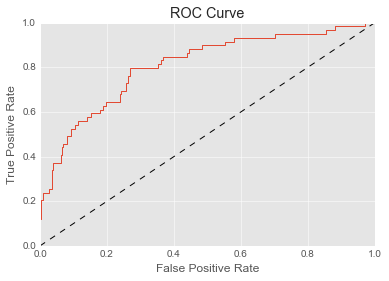

In [456]:
#Generating ROC Curve
logit_pred_prob = model_logit.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, logit_pred_prob)

# Plot ROC curve
plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

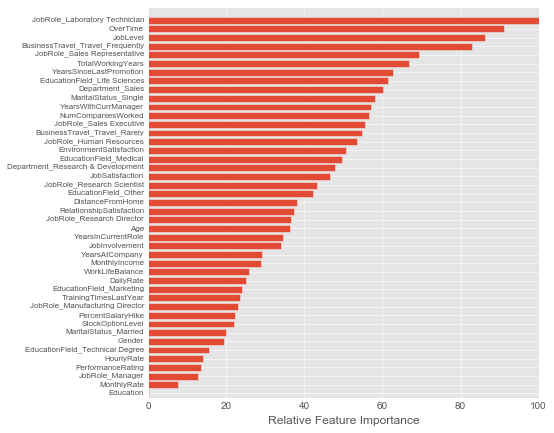

In [457]:
feature_importance_l = abs(model_logit.coef_[0])
feature_importance_l = 100.0 * (feature_importance_l / feature_importance_l.max())
sorted_idx = np.argsort(feature_importance_l)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(7,7))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance_l[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(x_scaled.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.show()
#However the sklearn.linear_model.LogisticRegression does not provide the p-values so we are not able to make
#any inference about the significance of each independent variable, for that reasons statsmodel 

In [458]:
model_l = sm.Logit(y, x_scaled)
model_stats_logit = model_l.fit()
model_stats_logit.summary2()

Optimization terminated successfully.
         Current function value: 0.617946
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
=================================================================================
Model:                     Logit                 No. Iterations:        5.0000   
Dependent Variable:        Attrition             Pseudo R-squared:      -0.399   
Date:                      2018-11-10 22:56      AIC:                   1904.7611
No. Observations:          1470                  BIC:                   2137.6538
Df Model:                  43                    Log-Likelihood:        -908.38  
Df Residuals:              1426                  LL-Null:               -649.29  
Converged:                 1.0000                Scale:                 1.0000   
---------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------
Age                               -0.1524   0.0818 -1.8638 0.0623 -0.3126  0.0079
DailyRate                         -0.0488   0.0573 -0.8519 0.3942 -0.1611  0.0635
DistanceFromHome                   0.1369   0.0570  2.4008 0.0164  0.0251  0.2487
Education                          0.0071   0.0585  0.1218 0.9031 -0.1076  0.1219
EnvironmentSatisfaction           -0.2073   0.0576 -3.5976 0.0003 -0.3202 -0.0944
Gender                             0.0813   0.0573  1.4185 0.1560 -0.0310  0.1936
HourlyRate                        -0.0166   0.0571 -0.2902 0.7717 -0.1285  0.0953
JobInvolvement                    -0.1947   0.0582 -3.3441 0.0008 -0.3088 -0.0806
JobLevel                          -0.0177   0.2112 -0.0839 0.9331 -0.4317  0.3962
JobSatisfaction                   -0.1918   0.0573 -3.3476 0.0008 -0.3041 -0.0795
MonthlyIncome                      0.0302   0.2383  0.1267 0.8991 -0.4369  0.4973
MonthlyRate                        0.0120   0.0569  0.2101 0.8336 -0.0996  0.1236
NumCompaniesWorked                 0.1990   0.0636  3.1280 0.0018  0.0743  0.3237
OverTime                           0.4380   0.0587  7.4626 0.0000  0.3230  0.5531
PercentSalaryHike                 -0.0349   0.0902 -0.3870 0.6987 -0.2117  0.1419
PerformanceRating                  0.0336   0.0899  0.3740 0.7084 -0.1426  0.2098
RelationshipSatisfaction          -0.1131   0.0570 -1.9849 0.0472 -0.2248 -0.0014
StockOptionLevel                  -0.0622   0.0777 -0.8007 0.4233 -0.2145  0.0901
TotalWorkingYears                 -0.1389   0.1279 -1.0859 0.2775 -0.3895  0.1118
TrainingTimesLastYear             -0.0783   0.0575 -1.3620 0.1732 -0.1909  0.0344
WorkLifeBalance                   -0.1011   0.0572 -1.7670 0.0772 -0.2133  0.0110
YearsAtCompany                     0.1566   0.1230  1.2733 0.2029 -0.0845  0.3978
YearsInCurrentRole                -0.1551   0.0943 -1.6457 0.0998 -0.3399  0.0296
YearsSinceLastPromotion            0.1616   0.0734  2.2001 0.0278  0.0176  0.3056
YearsWithCurrManager              -0.1566   0.0943 -1.6606 0.0968 -0.3415  0.0282
MaritalStatus_Married              0.0324   0.0764  0.4238 0.6717 -0.1173  0.1820
MaritalStatus_Single               0.2483   0.0981  2.5306 0.0114  0.0560  0.4405
JobRole_Human Resources            0.1834   0.1535  1.1948 0.2322 -0.1175  0.4842
JobRole_Laboratory Technician      0.2426   0.1020  2.3799 0.0173  0.0428  0.4425
JobRole_Manager                    0.0617   0.1150  0.5367 0.5915 -0.1637  0.2872
JobRole_Manufacturing Director     0.0218   0.0784  0.2783 0.7808 -0.1318  0.1755
JobRole_Research Director         -0.0038   0.0929 -0.0404 0.9678 -0.1859  0.1784
JobRole_Research Scientist         0.0741   0.1054  0.7032 0.4820 -0.1324  0.2806
JobRole_Sales Executive            0.1977   0.2161  0.9148 0.3603 -0.2259  0.6213
JobRole_Sales Representative       0.2852   0.1353  2.1081 0.0350  0.0200  0.5504
Department_Research & Development  0.2834   0.3786  0.7487 0.4541 -0.4586  1.0254
Department_Sales                   0.2187   0.378

In [459]:
#Transforming the summary into pandas dataframe to fileter for significant variables, with alpha=0.05
summary_table = round(pd.DataFrame({"coeff":model_stats_logit.params,"pvals": model_stats_logit.pvalues}),4)
important_sum_table=summary_table.loc[summary_table['pvals'] < 0.05].loc[summary_table['coeff']>0].sort_values('coeff',
                                                                                                               ascending=False)
important_sum_table

,coeff,pvals
OverTime,0.4380,0.0000
JobRole_Sales Representative,0.2852,0.0350
BusinessTravel_Travel_Frequently,0.2810,0.0013
MaritalStatus_Single,0.2483,0.0114
JobRole_Laboratory Technician,0.2426,0.0173
NumCompaniesWorked,0.1990,0.0018
YearsSinceLastPromotion,0.1616,0.0278
DistanceFromHome,0.1369,0.0164


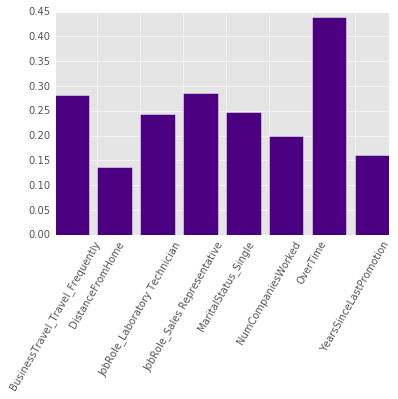

In [460]:
plt.bar(important_sum_table.index, important_sum_table['coeff'],color='indigo')
plt.xticks(rotation=60)
plt.style.use('classic')
plt.show()

##### Evaluation

We can obvserve that overall accuracies on train and test data are somewhere around 78%. Keeping this in mind and the low score on cross-validation standard deviation we can assume that the model is not overfitting, yet it is providing only average predictive power since both Roc Auc and Recall scores are low. From the table above we are able to see the important factors. 

Problem 2 ​(30 points). Use Employee_attition.csv dataset uploaded to Moodle to analyze employee churn. Use Decision Tree Classification to obtain the most important features. Evaluate the model and summarize results. Which model was better?

In [461]:
model_tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_tree.fit(x_train,y_train)
print("Accuracy on train set",model_tree.score(x_train,y_train)*100)
print("Accuracy on test set",model_tree.score(x_test,y_test)*100)

Accuracy on train set 100.0
Accuracy on test set 75.54347826086956


In [462]:
tree_pred = model_tree.predict(x_test)
print("Mean Squared Error",mean_squared_error(y_test,tree_pred))
print("Roc Auc Score",roc_auc_score(y_test,tree_pred)*100)
print("Mean of Cross-Validation Scores",cross_val_score(model_tree,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').mean()*100)

Mean Squared Error 0.24456521739130435
Roc Auc Score 57.32543469913883
Mean of Cross-Validation Scores 60.10054532613118


In [463]:
print(confusion_matrix(y_test, tree_pred))
print("-"*100)
print(classification_report(y_test, tree_pred))

[[260  49]
 [ 41  18]]
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.86      0.84      0.85       309
          1       0.27      0.31      0.29        59

avg / total       0.77      0.76      0.76       368



In [464]:
importances = model_tree.feature_importances_
features = pd.DataFrame(data = importances, columns = ["importance"], 
                        index = x_scaled.columns)
features.sort_values('importance', ascending=False)

,importance
Age,0.120973
YearsAtCompany,0.100857
DailyRate,0.072905
DistanceFromHome,0.071858
NumCompaniesWorked,0.059975
HourlyRate,0.059666
OverTime,0.057646
MonthlyIncome,0.052896
EnvironmentSatisfaction,0.040706
WorkLifeBalance,0.036157


In [465]:
#I will apply GridSearcCV to find best parameters
max_depth_values = [k for k in range(5,21)]
min_sample_values = [k for k in range(4,22,2)]
min_samples_split_values= [k for k in range(6,16,2)]

grid_search_dt_parameters = {"max_depth":max_depth_values, 
                             "min_samples_leaf":min_sample_values, 
                             "min_samples_split":min_samples_split_values}
grid_search_dt=GridSearchCV(model_tree,grid_search_dt_parameters, scoring='roc_auc')
grid_search_dt.fit(x_train, y_train)
print(grid_search_dt.best_params_)

{'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 6}


In [466]:
model_tree_tuned = DecisionTreeClassifier(random_state=42,class_weight='balanced', 
                                          max_depth=7,min_samples_leaf=20,min_samples_split=6)
model_tree_tuned.fit(x_train,y_train)
print("Accuracy on train set",model_tree_tuned.score(x_train,y_train)*100)
print("Accuracy on test set",model_tree_tuned.score(x_test,y_test)*100)
tuned_tree_pred = model_tree_tuned.predict(x_test)
print("Mean Squared Error",mean_squared_error(y_test,tuned_tree_pred))
print("Roc Auc Score",roc_auc_score(y_test,tuned_tree_pred)*100)
print("Mean of Cross-Validation Scores",cross_val_score(model_tree_tuned,x_scaled, 
                                                    y,cv=5,scoring='roc_auc').mean()*100)
print("-"*100)
print(confusion_matrix(y_test, tuned_tree_pred))
print("-"*100)
print(classification_report(y_test, tuned_tree_pred))

Accuracy on train set 74.41016333938293
Accuracy on test set 69.56521739130434
Mean Squared Error 0.30434782608695654
Roc Auc Score 67.47847073665734
Mean of Cross-Validation Scores 71.81199475876228
----------------------------------------------------------------------------------------------------
[[218  91]
 [ 21  38]]
----------------------------------------------------------------------------------------------------
             precision    recall  f1-score   support

          0       0.91      0.71      0.80       309
          1       0.29      0.64      0.40        59

avg / total       0.81      0.70      0.73       368



In [467]:
new_importances = model_tree_tuned.feature_importances_
new_features = pd.DataFrame(data = new_importances, columns = ["importance"], 
                        index = x_scaled.columns)
new_features.sort_values('importance', ascending=False).head(3)

,importance
YearsAtCompany,0.212448
Age,0.184810
OverTime,0.171338


###### Evaluation

The intitial model was clearly overfitting because of high difference in test and train data accuracies. After applying grid search we were able to minimize overfitting and increase the Roc Auc Curve. In this data the Logistic regression model seems more appropriate, since it not only provides better accuracies, but also is more interpretable. Importantly feature importancies do not give full picture about the significant independent variables.

Use education.xlsx dataset uploaded to Moodle to analyze the satisfaction from the educational program. Use PLS regression to predict satisfaction which is described by 3 variables: sat.glad, sat.expe, sat.over. You can find the description of data in the separate sheet called “Description of data.” Evaluate the model and summarize results.

In [468]:
data_pls = pd.read_excel('https://raw.githubusercontent.com/raffisahakyan/Raw_Data/master/education.xlsx', index_col='num')
data_pls.info()
print("\n"+"-"*80+'\n')
data_pls.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 1 to 181
Data columns (total 26 columns):
sup.help        181 non-null int64
sup.under       181 non-null int64
sup.safe        181 non-null int64
sup.conc        181 non-null int64
adv.comp        181 non-null int64
adv.acces       181 non-null int64
adv.comm        181 non-null int64
adv.qual        181 non-null int64
tut.prof        181 non-null int64
tut.sched       181 non-null int64
tut.stud        181 non-null int64
tut.qual        181 non-null int64
val.devel       181 non-null int64
val.deci        181 non-null int64
val.meet        181 non-null int64
val.info        181 non-null int64
sat.glad        181 non-null int64
sat.expe        181 non-null int64
sat.over        181 non-null int64
loy.proud       181 non-null int64
loy.recom       181 non-null int64
loy.asha        181 non-null int64
loy.back        181 non-null int64
gender          181 non-null object
scholarships    181 non-null object
job             18

,sup.help,sup.under,sup.safe,sup.conc,adv.comp,adv.acces,adv.comm,adv.qual,tut.prof,tut.sched,...,sat.glad,sat.expe,sat.over,loy.proud,loy.recom,loy.asha,loy.back,gender,scholarships,job
num,,,,,,,,,,,,,,,,,,,,,
1,7,1,7,4,5,5,6,6,5,4,...,7,7,7,7,7,1,7,female,yes_scholship,no_job
2,7,1,6,4,6,6,5,6,6,6,...,7,7,7,7,7,1,7,female,yes_scholship,yes_job
3,6,1,6,6,6,6,6,6,6,6,...,7,6,6,7,7,1,7,female,yes_scholship,no_job


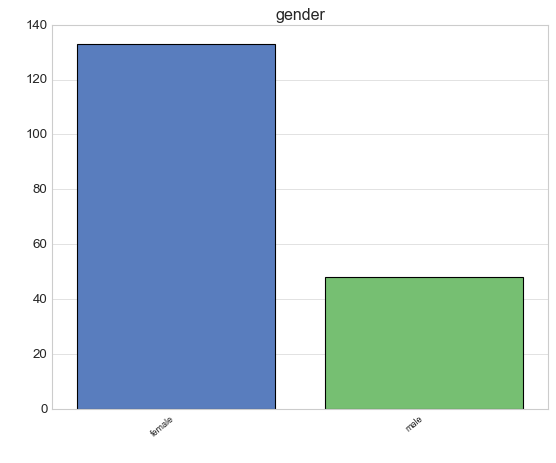

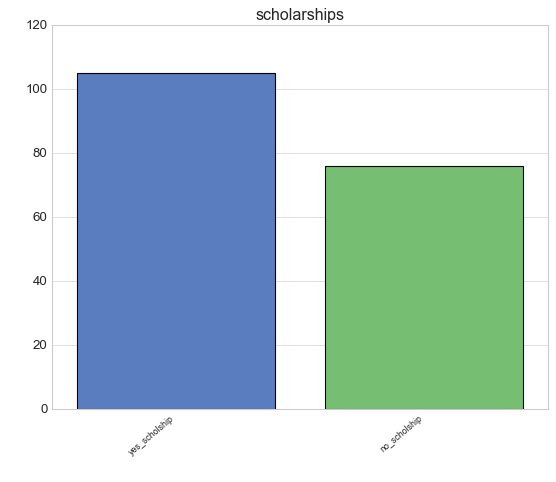

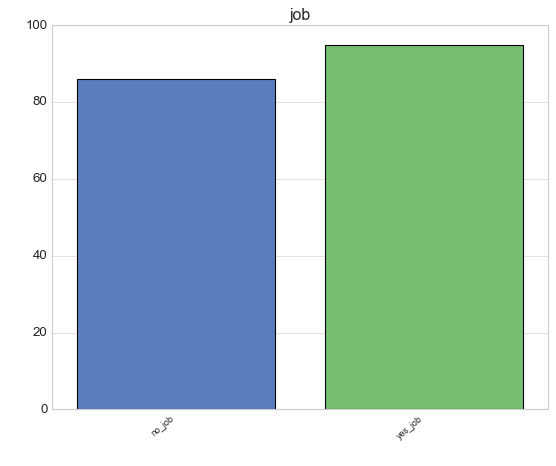

In [469]:
data_pls = data_pls.loc[:,data_pls.apply(pd.Series.nunique) != 1]
data_numeric_pls=data_pls.select_dtypes(exclude="object")
data_object_pls=data_pls.select_dtypes(include="object")

sns.set_style("whitegrid")
for i in data_object_pls.columns:
    ax = sns.countplot(data_object_pls[i], palette='muted')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=40, ha="right")
    ax.set_title(i)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    plt.show()

In [470]:
data_pls['scholarships']=data_pls['scholarships'].astype("category").cat.reorder_categories(['no_scholship','yes_scholship']).cat.codes 
data_pls['gender']=data_pls['gender'].astype("category").cat.reorder_categories(['female','male']).cat.codes 
data_pls['job']=data_pls['job'].astype("category").cat.reorder_categories(['no_job','yes_job']).cat.codes 

In [471]:
y_pls=data_pls[['sat.glad','sat.expe','sat.over']]
x_pls=scale(data_pls.drop(columns=['sat.glad','sat.expe','sat.over']))
X_train, X_test, Y_train, Y_test = train_test_split(x_pls,y_pls,test_size=.28,random_state=42)

In [472]:
model_pls = PLSRegression(n_components=9)
model_pls.fit(X_train,Y_train)
pls_pred=model_pls.predict(X_test)
round(model_pls.score(X_test,Y_test)*100,2)

48.79

In [473]:
pls_coef=pd.DataFrame(model_pls.coef_)
pls_coef.head(4)

,0,1,2
0,-0.075616,-0.014674,-0.075654
1,-0.047191,-0.127366,-0.050504
2,0.044614,0.105631,0.040595
3,0.090646,0.109411,0.002735


In [474]:
sc=pd.DataFrame(model_pls.x_scores_)
sc.head(10)

,0,1,2,3,4,5,6,7,8
0,-2.788738,1.489199,1.201980,-1.250858,-0.464853,0.526762,0.270691,-1.178820,-0.390273
1,1.788767,-0.060853,0.665777,1.416771,-0.003986,0.013337,0.305239,0.056019,-0.637170
2,1.055221,0.026894,1.509088,-0.350263,0.323466,0.035470,1.933200,0.239098,0.417334
3,-2.901443,-0.143741,0.316423,-0.159708,0.420391,0.638316,-0.963986,1.043899,-1.054681
4,0.857559,0.028657,-0.704829,1.801314,1.476107,-0.365596,-0.220965,0.435044,0.551029
5,3.388862,-0.596006,0.032897,0.340744,-0.666315,-0.109902,-0.023875,-0.602104,0.372346
6,-5.033430,-0.683986,-0.900937,-1.829075,-0.435480,0.448660,1.056465,-0.029467,0.679621
7,1.785534,0.927637,-1.678931,0.804084,-0.322820,0.554491,-0.436644,0.475977,-0.390648
8,3.240947,-0.483080,-0.213808,1.130174,-0.448482,0.556071,0.654063,-0.082155,0.215501
9,1.044556,-0.063267,1.631094,0.632008,-0.173149,-0.404928,0.361568,0.843764,0.259443


In [475]:
var_xcores=np.var(model_pls.x_scores_,axis=0)
total_var=np.sum(np.var(X_train,axis=0))
total_var=np.sum(np.var(X_train,axis=0))

X_Variance=pd.DataFrame((var_xcores/total_var).round(3), columns={"X_Variance"}).reset_index()
X_Variance = X_Variance.rename(columns={'index': 'Latent_Factors'})
X_Variance['Cummulative_X_Variance'] = X_Variance['X_Variance'].cumsum().round(3) #calculates cummulative variance
print(X_Variance)

   Latent_Factors  X_Variance  Cummulative_X_Variance
0               0       0.380                   0.380
1               1       0.053                   0.433
2               2       0.058                   0.491
3               3       0.043                   0.534
4               4       0.032                   0.566
5               5       0.026                   0.592
6               6       0.032                   0.624
7               7       0.022                   0.646
8               8       0.022                   0.668


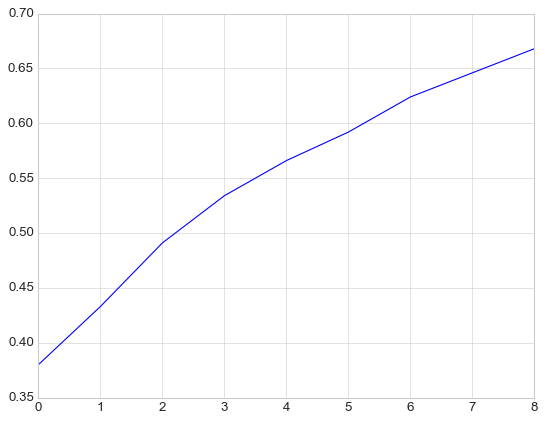

In [476]:
plt.plot(X_Variance.Latent_Factors,X_Variance.Cummulative_X_Variance)
plt.show()

###### Evaluation

The PLS model accuracy is quite low, so this model might seem inappropriate for this dataset, or additional changes have to be applied. We were able to achieve 66.8% cumulative x variance in the PLS model.